#### Imports

In [1]:
import os
from pathlib import Path

import glob
import gc 

import cv2
import time
import numpy as np
import pandas as pd

import PIL
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('fivethirtyeight') 
%matplotlib inline

import pytorch_lightning as pl

import torch
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
ab_path = "/home/vmuser/2024/ACML/data/ab/ab/ab1.npy"
l_path = "/home/vmuser/2024/ACML/data/l/gray_scale.npy"

In [3]:
ab_df = np.load(ab_path)[0:1000]
L_df = np.load(l_path)[0:1000]

dataset = (L_df, ab_df)
gc.collect() #garbage collector

22

In [4]:
def lab_to_rgb(L, ab):
    """
    Takes an image or a batch of images and converts from LAB space to RGB
    """
    L = L  * 100
    ab = (ab - 0.5) * 128 * 2
    Lab = torch.cat([L, ab], dim=2).numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

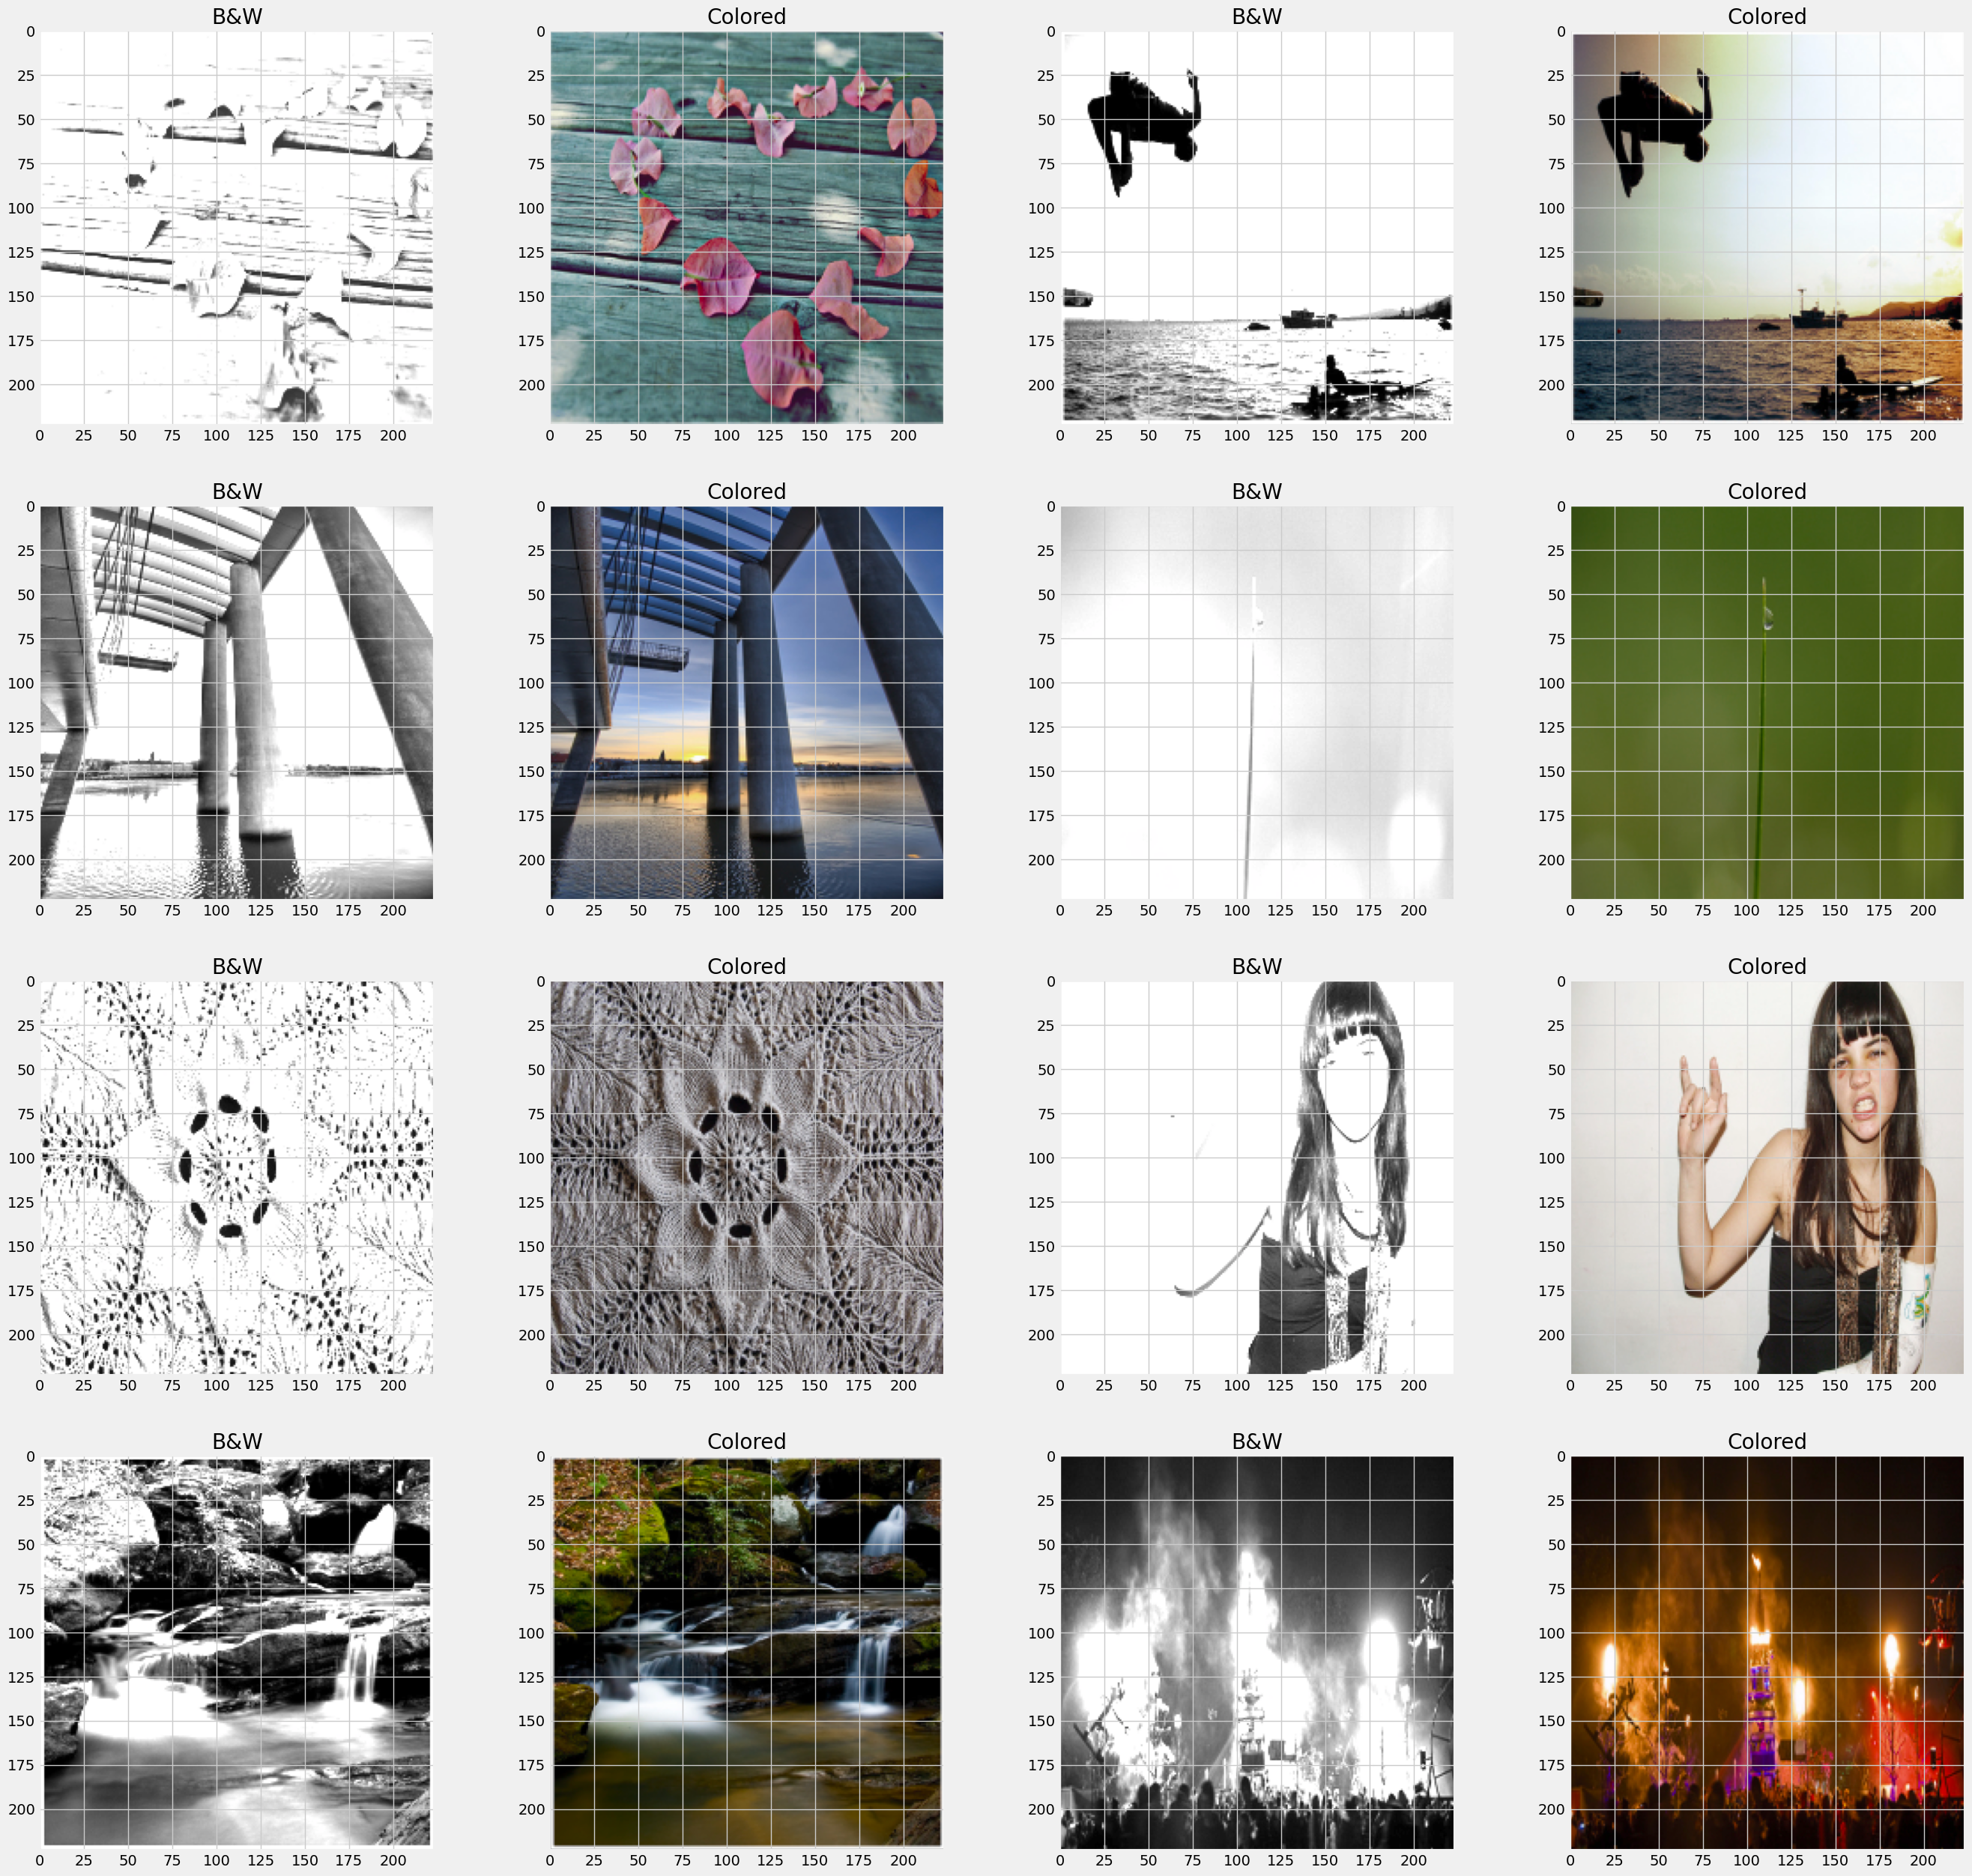

In [5]:
plt.figure(figsize=(30,30))
for i in range(1,16,2):
    plt.subplot(4,4,i)
    img = np.zeros((224,224,3))
    img[:,:,0] = L_df[i]
    plt.title('B&W')
    plt.imshow(lab2rgb(img))
    
    plt.subplot(4,4,i+1)
    img[:,:,1:] = ab_df[i]
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    plt.title('Colored')
    plt.imshow(img)

In [7]:
class ImageColorizationDataset(Dataset):
    ''' Black and White (L) Images and corresponding A&B Colors'''
    def __init__(self, dataset, transform=None):
        '''
        :param dataset: Dataset name.
        :param data_dir: Directory with all the images.
        :param transform: Optional transform to be applied on sample
        '''
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset[0])
    
    def __getitem__(self, idx):
        L = np.array(dataset[0][idx]).reshape((224,224,1))
        L = transforms.ToTensor()(L)
        
        ab = np.array(dataset[1][idx])
        ab = transforms.ToTensor()(ab)

        return ab, L

In [8]:
batch_size = 1

# Prepare the Datasets
train_dataset = ImageColorizationDataset(dataset = (L_df, ab_df))
test_dataset = ImageColorizationDataset(dataset = (L_df, ab_df))

# Build DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True, pin_memory = True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle = False, pin_memory = True)

In [9]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,kernel_size=3,padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.identity_map = nn.Conv2d(in_channels, out_channels,kernel_size=1,stride=stride)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, inputs):
        x = inputs.clone().detach()
        out = self.layer(x)
        residual  = self.identity_map(inputs)
        skip = out + residual
        return self.relu(skip)

In [10]:
class DownSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.layer = nn.Sequential(
            nn.MaxPool2d(2),
            ResBlock(in_channels, out_channels)
        )

    def forward(self, inputs):
        return self.layer(inputs)

In [11]:
class UpSampleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.res_block = ResBlock(in_channels + out_channels, out_channels)
        
    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        x = torch.cat([x, skip], dim=1)
        x = self.res_block(x)
        return x

In [12]:
class Generator(nn.Module):
    def __init__(self, input_channel, output_channel, dropout_rate = 0.2):
        super().__init__()
        self.encoding_layer1_ = ResBlock(input_channel,64)
        self.encoding_layer2_ = DownSampleConv(64, 128)
        self.encoding_layer3_ = DownSampleConv(128, 256)
        self.bridge = DownSampleConv(256, 512)
        self.decoding_layer3_ = UpSampleConv(512, 256)
        self.decoding_layer2_ = UpSampleConv(256, 128)
        self.decoding_layer1_ = UpSampleConv(128, 64)
        self.output = nn.Conv2d(64, output_channel, kernel_size=1)
        self.dropout = nn.Dropout2d(dropout_rate)
        
    def forward(self, inputs):
        ###################### Enocoder #########################
        e1 = self.encoding_layer1_(inputs)
        e1 = self.dropout(e1)
        e2 = self.encoding_layer2_(e1)
        e2 = self.dropout(e2)
        e3 = self.encoding_layer3_(e2)
        e3 = self.dropout(e3)
        
        ###################### Bridge #########################
        bridge = self.bridge(e3)
        bridge = self.dropout(bridge)
        
        ###################### Decoder #########################
        d3 = self.decoding_layer3_(bridge, e3)
        d2 = self.decoding_layer2_(d3, e2)
        d1 = self.decoding_layer1_(d2, e1)
        
        ###################### Output #########################
        output = self.output(d1)
        return output

In [13]:
model = Generator(1,2).to(device)
summary(model, (1, 224, 224), batch_size = 1)

In [15]:
class Critic(nn.Module):
    def __init__(self, in_channels=3):
        super(Critic, self).__init__()

        def critic_block(in_filters, out_filters, normalization=True):
            """Returns layers of each critic block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *critic_block(in_channels, 64, normalization=False),
            *critic_block(64, 128),
            *critic_block(128, 256),
            *critic_block(256, 512),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, ab, l):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((ab, l), 1)
        output = self.model(img_input)
        return output

In [16]:
model = Critic(3).to(device)
summary(model, [(2, 224, 224), (1, 224, 224)], batch_size = 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 112, 112]           3,136
         LeakyReLU-2          [1, 64, 112, 112]               0
            Conv2d-3           [1, 128, 56, 56]         131,200
    InstanceNorm2d-4           [1, 128, 56, 56]               0
         LeakyReLU-5           [1, 128, 56, 56]               0
            Conv2d-6           [1, 256, 28, 28]         524,544
    InstanceNorm2d-7           [1, 256, 28, 28]               0
         LeakyReLU-8           [1, 256, 28, 28]               0
            Conv2d-9           [1, 512, 14, 14]       2,097,664
   InstanceNorm2d-10           [1, 512, 14, 14]               0
        LeakyReLU-11           [1, 512, 14, 14]               0
AdaptiveAvgPool2d-12             [1, 512, 1, 1]               0
          Flatten-13                   [1, 512]               0
           Linear-14                   

In [17]:
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [18]:
def display_progress(cond, real, fake, current_epoch = 0, figsize=(20,15)):
    """
    Save cond, real (original) and generated (fake)
    images in one panel 
    """
    cond = cond.detach().cpu().permute(1, 2, 0)   
    real = real.detach().cpu().permute(1, 2, 0)
    fake = fake.detach().cpu().permute(1, 2, 0)
    
    images = [cond, real, fake]
    titles = ['input','real','generated']
    print(f'Epoch: {current_epoch}')
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    for idx,img in enumerate(images):
        if idx == 0:
            ab = torch.zeros((224,224,2))
            img = torch.cat([images[0]* 100, ab], dim=2).numpy()
            imgan = lab2rgb(img)
        else:
            imgan = lab_to_rgb(images[0],img)
        ax[idx].imshow(imgan)
        ax[idx].axis("off")
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title))
    plt.show()

In [ ]:
class CWGAN(pl.LightningModule):

    def __init__(self, in_channels, out_channels, learning_rate=0.0002, lambda_recon=100, display_step=10, lambda_gp=10, lambda_r1=10,):

        super().__init__()
        self.save_hyperparameters()
        
        self.display_step = display_step
        
        self.generator = Generator(in_channels, out_channels)
        self.critic = Critic(in_channels + out_channels)
        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
        self.optimizer_C = optim.Adam(self.critic.parameters(), lr=learning_rate, betas=(0.5, 0.9))
        self.lambda_recon = lambda_recon
        self.lambda_gp = lambda_gp
        self.lambda_r1 = lambda_r1
        self.recon_criterion = nn.L1Loss()
        self.generator_losses, self.critic_losses  =[],[]
    
    def configure_optimizers(self):
        return [self.optimizer_C, self.optimizer_G]
        
    def generator_step(self, real_images, conditioned_images):
        # WGAN has only a reconstruction loss
        self.optimizer_G.zero_grad()
        fake_images = self.generator(conditioned_images)
        recon_loss = self.recon_criterion(fake_images, real_images)
        recon_loss.backward()
        self.optimizer_G.step()
        
        # Keep track of the average generator loss
        self.generator_losses += [recon_loss.item()]
        
        
    def critic_step(self, real_images, conditioned_images):
        self.optimizer_C.zero_grad()
        fake_images = self.generator(conditioned_images)
        fake_logits = self.critic(fake_images, conditioned_images)
        real_logits = self.critic(real_images, conditioned_images)
        
        # Compute the loss for the critic
        loss_C = real_logits.mean() - fake_logits.mean()

        # Compute the gradient penalty
        alpha = torch.rand(real_images.size(0), 1, 1, 1, requires_grad=True)
        alpha = alpha.to(device)
        interpolated = (alpha * real_images + (1 - alpha) * fake_images.detach()).requires_grad_(True)
        
        interpolated_logits = self.critic(interpolated, conditioned_images)
        
        grad_outputs = torch.ones_like(interpolated_logits, dtype=torch.float32, requires_grad=True)
        gradients = torch.autograd.grad(outputs=interpolated_logits, inputs=interpolated, grad_outputs=grad_outputs,create_graph=True, retain_graph=True)[0]

        
        gradients = gradients.view(len(gradients), -1)
        gradients_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        loss_C += self.lambda_gp * gradients_penalty
        
        # Compute the R1 regularization loss
        r1_reg = gradients.pow(2).sum(1).mean()
        loss_C += self.lambda_r1 * r1_reg

        # Backpropagation
        loss_C.backward()
        self.optimizer_C.step()
        self.critic_losses += [loss_C.item()]
        
    def training_step(self, batch, batch_idx, optimizer_idx):
        real, condition = batch
        if optimizer_idx == 0:
            self.critic_step(real, condition)
        elif optimizer_idx == 1:
            self.generator_step(real, condition)
        gen_mean = sum(self.generator_losses[-self.display_step:]) / self.display_step
        crit_mean = sum(self.critic_losses[-self.display_step:]) / self.display_step
        if self.current_epoch%self.display_step==0 and batch_idx==0 and optimizer_idx==1:
            fake = self.generator(condition).detach()
            torch.save(cwgan.generator.state_dict(), "ResUnet_"+ str(self.current_epoch) +".pt")
            torch.save(cwgan.critic.state_dict(), "PatchGAN_"+ str(self.current_epoch) +".pt")
            print(f"Epoch {self.current_epoch} : Generator loss: {gen_mean}, Critic loss: {crit_mean}")
            display_progress(condition[0], real[0], fake[0], self.current_epoch)

: 